In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
from os.path import join
import pandas as pd
import numpy as np
import numpy.ma as ma

from util.files import *
from util.const import *
from util.ddfs import *

In [3]:
# FIPS will be passed in as an argument, one day...
FIPS = '34007'
# STATE ABBR and NATION will be derived from FIPS, one day...
STATEABBR = 'NJ'
NATION = 'US'

# I think it also could make sense to pass in scenario and
# ddf type as arguments. For main results
# we're using 'mid' and 'naccs' but for generating
# our sensitivity analysis results we will need to pass
# in the other scenarios and 'hazus'
# Very well suited for snakemake :) 
SCENARIO = 'Mid'
DDF_TYPE = 'naccs'

# Load and Prepare Data

In [4]:
# Load the ensemble data, along with the optimal & dfe
# elevation results
opt_elev_filename = 'ens_opt_elev_' + DDF_TYPE + '_' + SCENARIO + '.pqt'
dfe_elev_filename = 'ens_dfe_elev_' + DDF_TYPE + '_' + SCENARIO + '.pqt'
ens_filename = 'ensemble_' + SCENARIO + '.pqt'

ens_df = pd.read_parquet(join(FO, ens_filename))
opt_elev_df = pd.read_parquet(join(EXP_DIR_I, FIPS, opt_elev_filename))
dfe_elev_df = pd.read_parquet(join(EXP_DIR_I, FIPS, dfe_elev_filename))

In [5]:
# Merge on fd_id and sow_ind to get eal_avoid, elev_cost, and opt_elev
# into the ensemble
ens_df = ens_df.merge(opt_elev_df,
                      on=['fd_id', 'sow_ind'],
                      suffixes=['','_opt'])
# Merge dfe_elev_df as well, adding suffixes
ens_df = ens_df.merge(dfe_elev_df,
                      on=['fd_id', 'sow_ind'],
                      suffixes=['','_dfe'])

In [6]:
# We also need to load in the links between structures and the
# social vulnerability data for sorting rules
sovi_filepath = join(VULN_DIR_I, 'social', FIPS, 'c_indicators.pqt')
sovi_df = pd.read_parquet(sovi_filepath)

In [ ]:
# Get the difference of benefits and costs
ens_df['npv_opt'] = ens_df['pv_avoid'] - ens_df['pv_cost']
ens_df['npv_dfe'] = ens_df['pv_avoid_dfe'] - ens_df['pv_cost_dfe']
# And the ratio
ens_df['bcr_opt'] = ens_df['pv_avoid']/ens_df['pv_cost']
ens_df['bcr_dfe'] = ens_df['pv_avoid_dfe']/ens_df['pv_cost_dfe']

# Calculate net present benefits

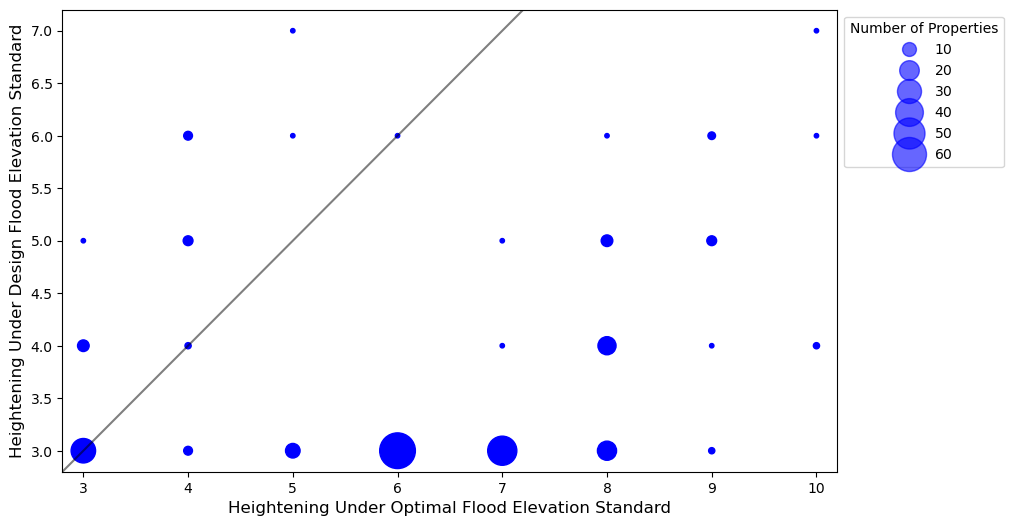

In [61]:
temp = ens_df.groupby('fd_id')['opt_elev'].first()
temp2 = ens_df.groupby('fd_id')['dfe_elev'].first()
comp = pd.concat([temp, temp2], axis=1)
comp_s = comp.groupby(['opt_elev', 'dfe_elev']).size().rename('n').reset_index()
comp_s['opt_elev'] = comp_s['opt_elev'].astype(int)
comp_s['dfe_elev'] = comp_s['dfe_elev'].astype(int)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(x=comp_s['opt_elev'],
                     y=comp_s['dfe_elev'],
                     color='blue',
                     s=10*comp_s['n'])
ax.axline([0, 0], [1, 1], color='black', alpha=.5)
ax.set_xlim([2.8, 10.2])
ax.set_ylim([2.8, 7.2])
ax.set_ylabel('Heightening Under Design Flood Elevation Standard', size=12)
ax.set_xlabel('Heightening Under Optimal Flood Elevation Standard', size=12)
handles, labels = scatter.legend_elements(prop="sizes",
                                          alpha=0.6,
                                          func=lambda x: x/10,
                                          num=5,
                                          color='blue')
ax.legend(handles,
          labels,
          bbox_to_anchor=(1, 1),
          title="Number of Properties")

# Allocate funding

In [ ]:
# Now that we have these values we can start sorting! 
# The sovi_df we loaded has the fd_id which are in different
# tracts
# We still need to calculate the household metrics for sorting
# We will sort until we expend our budget, which goes from 1 mil
# to 36 mil in investment costs in 5 mil increments
# For half the policies, the project BCR must be > 1, for
# the other half, the project BCR can be less than 1
# I don't think this rule will make a big difference in 
# our case study, but we shall see